<a href="https://colab.research.google.com/github/ashkree/ICT303_Practical/blob/main/Lab1_Rice_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install ucimlrepo
!pip install optuna

# Data Preprocessing

In [22]:
# fetching straight from uciml

from ucimlrepo import fetch_ucirepo

# fetch dataset
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

# data (as pandas dataframes)
df = rice_cammeo_and_osmancik.data.original

# metadata
print(rice_cammeo_and_osmancik.metadata)

# variable information
print(rice_cammeo_and_osmancik.variables)


{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'ID': 276, 'type': 'NATIVE', 'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'venue': 'International Journal of Intel

In [23]:
# turning headers lowercase for convenience
df.rename(columns=str.lower, inplace=True)

df.head()

,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


## Data Analysis

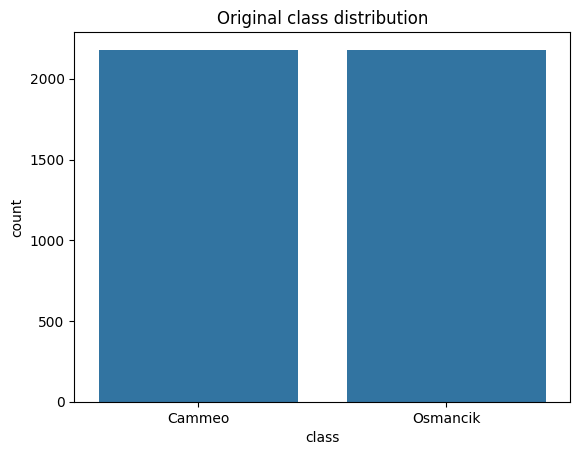

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# original
sns.countplot(x='class', data=df)
plt.title("Original class distribution")
plt.show()

In [24]:
# balancing classes for better training
# using smote oversampling
df['class'].value_counts()

,count
class,
Osmancik,2180
Cammeo,1630


In [25]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# instantiating smote resampler
smote = SMOTE(random_state=42, sampling_strategy='auto')

# smote resampling
X_smote, y_smote = smote.fit_resample(df.drop('class', axis=1), df['class'])

# rebuilding dataset
df = pd.concat(
    [pd.DataFrame(X_smote, columns=X_smote.columns),
     pd.Series(y_smote, name='class')],
    axis=1
)

print("After resampling")
df['class'].value_counts()

After resampling


,count
class,
Cammeo,2180
Osmancik,2180


# Model Training

In [35]:
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 1) Split dataset between features (X) and targets (y) with label encoding
X = df.drop('class', axis=1)
y = df['class'].map({'Osmancik': 0, 'Cammeo': 1})

In [36]:
from sklearn.model_selection import train_test_split

# 2) 80 - 20 training split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [37]:
# 3) Define objective function for Bayesian Hyperparameter Optimisation
# and k-fold cross validation
def objective(trial):

    # 2.1) suggest hyperparameters
    C       = trial.suggest_loguniform('C', 1e-4, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # solver must match penalty
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])

    # 2.2) create model
    # Using LogisticRegression here since it'll provide a more aac
    clf = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=1000,
        random_state=42
    )

    # 2.3) k-fold cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # use ROC-AUC (or change to 'accuracy', 'f1', etc.)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    return scores.mean()


In [38]:
# 4) run the optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=True)

# 5) best result on training set
print("Best ROC-AUC:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-05-24 11:30:24,047] A new study created in memory with name: no-name-d682663a-a6d1-43a8-88cb-e4bb68f9a5e1


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-24 11:30:46,602] Trial 0 finished with value: 0.9809696181457468 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1'}. Best is trial 0 with value: 0.9809696181457468.
[I 2025-05-24 11:31:39,777] Trial 1 finished with value: 0.9810797280319783 and parameters: {'C': 0.39079671568228835, 'penalty': 'l1'}. Best is trial 1 with value: 0.9810797280319783.
[I 2025-05-24 11:32:02,436] Trial 2 finished with value: 0.9088416690990307 and parameters: {'C': 0.00022310108018679258, 'penalty': 'l1'}. Best is trial 1 with value: 0.9810797280319783.
[I 2025-05-24 11:32:02,767] Trial 3 finished with value: 0.9810190015049043 and parameters: {'C': 1.7718847354806828, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9810797280319783.
[I 2025-05-24 11:32:03,440] Trial 4 finished with value: 0.9804269768466313 and parameters: {'C': 0.0012329623163659848, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9810797280319783.
[I 2025-05-24 11:32:25,946] Tria

In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    brier_score_loss,
    classification_report,
    confusion_matrix
)

# 6) Model Evaluation
best = study.best_params
best_clf = LogisticRegression(**best, max_iter=1000, random_state=42)
best_clf.fit(X_train, y_train)

y_pred  = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:,1]

print("Accuracy:      ", accuracy_score(y_test, y_pred))
print("Precision:     ", precision_score(y_test, y_pred))
print("Recall:        ", recall_score(y_test, y_pred))
print("F1-score:      ", f1_score(y_test, y_pred))
print("ROC AUC:       ", roc_auc_score(y_test, y_proba))
print("Log‐loss:      ", log_loss(y_test, y_proba))
print("Brier score:   ", brier_score_loss(y_test, y_proba))

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.